In [569]:
import pandas as pd
import numpy as np
import psycopg2
import datetime
import argparse
import matplotlib.pyplot as plt

from sqlalchemy import create_engine


In [552]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [570]:
# parser = argparse.ArgumentParser(description='Forecast range of preloads for a campaign x site.')
# parser.add_argument('-u','--dbuser', help='The DB user to connect as')
# parser.add_argument('-p','--dbpass', help='The DB password to user when connecting.')

# args = parser.parse_args()
# USERNAME = args.dbuser
# PWD = args.dbpass
# DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
#            ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
#           ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

usage: ipykernel_launcher.py [-h] [-u DBUSER] [-p DBPASS]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/daniel.ryu/Library/Jupyter/runtime/kernel-bd032e5b-f361-4c1d-b861-6d95646e0d1d.json


SystemExit: 2

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3435: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [553]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [554]:
query_device_cnt = """
select
    date(createdate at time zone 'utc' at time zone 'est') as date
    , extract(hour from (f.createdate at time zone 'utc' at time zone 'est')) as hour
    , f.siteid as site_id
    , count(distinct imei) as device_count
from rawdata.dt_device_report f
join rawdata.site s
    on f.siteid = s.site_id
where
    date(createdate at time zone 'utc' at time zone 'est') >= current_date - 14
    and date(createdate at time zone 'utc' at time zone 'est') <= current_date - 1
    and kind = 'production'
    and s.site_name not like '%RDNS%'
    and f.processtypeid = 1
group by 1,2,3
"""

In [555]:
query_preloads = """
select
    date(ef.event_timestamp) as date 
    , extract(hour from ef.event_timestamp) as hour
    , ef.site_id
    , cd.app_identifier
    , ef.campaign_id
    , sum(preload_count) as preloads
    , sum(gross_revenue) as spend
from venus.event_fact ef
join venus.site_dimension sd
    on ef.site_id = sd.site_id
join venus.campaign_dimension cd 
    on ef.campaign_id = cd.campaign_id
    and cd.bid_price_per_download > 0
    and cd.billing_type_id = 2
where 
    date(ef.event_timestamp) >= current_date - 14
    and date(ef.event_timestamp) <= current_date - 1
group by 1,2,3,4,5
"""

### Run and combine query results

In [556]:
cur_atlas.execute(query_device_cnt)
df_device_cnt = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
df_device_cnt.set_index(['date','hour','site_id'], inplace = True)

In [557]:
cur_olympus.execute(query_preloads)
df_preloads = pd.DataFrame(cur_olympus.fetchall(), columns = [c[0] for c in cur_olympus.description])
df_preloads.set_index(['date','hour','site_id'], inplace = True)
df_preloads['spend'] = df_preloads['spend'].astype(float)

In [558]:
by_date_hour = df_preloads.join(df_device_cnt)

by_date_hour.reset_index(inplace = True)

# filter for sites with spend for a given campaign
by_date_hour['campaign_site_spend'] = by_date_hour.groupby(['campaign_id','site_id'])['spend'].transform('sum')
by_date_hour = by_date_hour[by_date_hour['campaign_site_spend'] > 0]
by_date_hour['spend'] = by_date_hour['spend'].astype(float)
by_date_hour['date'] = by_date_hour['date'].astype('datetime64')
by_date_hour

date  hour  site_id                              app_identifier  \
0      2021-04-20     0     7320                       com.tripledot.woodoku   
1      2021-04-20     0     7374                        com.dna.solitaireapp   
2      2021-04-20     0     7374                          com.onedebit.chime   
3      2021-04-20     0     7374                    com.gsn.android.tripeaks   
4      2021-04-20     0     7375                         com.facebook.katana   
...           ...   ...      ...                                         ...   
893056 2021-05-03    23    12619  com.microsoft.microsoftsolitairecollection   
893057 2021-05-03    23    12629                            com.razer.cortex   
893058 2021-05-03    23    12668                       br.com.marisa.android   
893059 2021-05-03    23    12687                            com.razer.cortex   
893060 2021-05-03    23    12692                            com.razer.cortex   

        campaign_id  preloads  spend  device_count  campaign_site_spend  
0             33029         1   0.30           1.0                 0.60  
1             29238         1   0.25           1.0                42.00  
2             33930         1   0.29           1.0                87.87  
3             26819         2   1.30           1.0               226.85  
4             32054         3   0.60           1.0               567.80  
...             ...       ...    ...           ...                  ...  
893056        32523         0   0.00           4.0                18.35  
893057        29352         2   0.06           3.0                 3.00  
893058        34365         0   0.00           NaN               422.60  
893059        29352         1   0.03           NaN                 0.24  
893060        29352         1   0.03           NaN                 9.45  

[881141 rows x 9 columns]

### Calculate computed metrics, combine into "by_hour" average over 14 days

In [560]:
by_date_hour['daily_cap_hour'] = by_date_hour.where(by_date_hour.preloads > 0).groupby(['date','campaign_id','site_id'])['hour'].transform('max')
by_date_hour['min_cap_hour'] = by_date_hour.groupby(['campaign_id','site_id'])['daily_cap_hour'].transform('min')
by_date_hour['mean_cap_hour'] = by_date_hour.groupby(['campaign_id','site_id'])['daily_cap_hour'].transform('mean')
by_date_hour['max_preloads'] = by_date_hour.groupby(['date','hour','site_id'])['preloads'].transform('max')
by_hour = by_date_hour.pivot_table(values = ['preloads','max_preloads','spend','device_count','min_cap_hour','mean_cap_hour']
                               , index = ['campaign_id','site_id','hour']
                               , aggfunc = {
                                   'preloads':'mean'
                                   ,'max_preloads':'mean'
                                   ,'spend':'mean'
                                   ,'device_count':'mean'
                                   ,'min_cap_hour':'max'
                                   ,'mean_cap_hour':'mean'
                               }).reset_index()

### Create hi- and lo- projections based on highest preloads for any campaign on a site x hour

In [561]:
campaign_site_hour = by_hour[['campaign_id','site_id','mean_cap_hour','min_cap_hour']].drop_duplicates().merge(pd.DataFrame({'hour':list(range(24))}), how = 'cross')
campaign_site_hour.set_index(['campaign_id','site_id','hour'], inplace = True)
by_hour.set_index(['campaign_id','site_id','hour'], inplace = True)
proj_byhour = by_hour[['device_count','max_preloads','preloads','spend']].join(campaign_site_hour, how = 'outer')
proj_byhour.reset_index(inplace = True)
by_hour.reset_index(inplace = True)

proj_byhour['cum_preloads'] = proj_byhour.fillna(0).groupby(['site_id','campaign_id'])['preloads'].transform('cumsum')
proj_byhour['cum_device_count'] = proj_byhour.fillna(0).groupby(['site_id','campaign_id'])['device_count'].transform('cumsum')
proj_byhour['cum_max_preloads'] = proj_byhour.fillna(0).groupby(['site_id','campaign_id'])['max_preloads'].transform('cumsum')
proj_byhour['preloads_to_device'] = proj_byhour['cum_preloads']/proj_byhour['cum_device_count']
proj_byhour['preloads_to_max'] = proj_byhour['cum_preloads']/proj_byhour['cum_max_preloads']

# hi prediction assumes preloads will converge to average of max preloads & avg percentage of device count starting at the earliest cap hour by day over past 2 weeks
proj_byhour['pred_preloads_hi'] = np.where(proj_byhour['hour'] < np.floor(proj_byhour['min_cap_hour'])
                                           , proj_byhour['preloads']
                                           , np.where(proj_byhour.device_count.isna()
                                                      , proj_byhour.max_preloads
                                                      , (proj_byhour['device_count']*proj_byhour['preloads_to_device'] + proj_byhour['max_preloads'])/2
                                                     )
                                          )

# lo prediction assumes preloads will converge to avg percentage of max preloads & device_count over past 2 weeks,
# starting at average cap hour by day over past 2 weeks (later than hi predictions start hour)
proj_byhour['pred_preloads_lo'] = np.where(proj_byhour['hour'] < np.floor(proj_byhour['min_cap_hour'])
                                           , proj_byhour['preloads']
                                           , np.where(proj_byhour.device_count.isna()
                                                      , proj_byhour.max_preloads
                                                      , (proj_byhour['device_count']*proj_byhour['preloads_to_device'] + proj_byhour['max_preloads']*proj_byhour['preloads_to_max'])/2
                                                     )
                                          )

proj_byhour.loc[(proj_byhour.campaign_id == 29004) & (proj_byhour.hour > 7)].sort_values(['hour','preloads'], ascending = [True,False]).head(30)

campaign_id  site_id  hour  device_count  max_preloads   preloads  \
57608        29004    12145     8    144.357143    118.428571  90.000000   
57224        29004    11656     8    119.000000    107.500000  75.714286   
57920        29004    12420     8     42.571429     82.714286  57.571429   
57272        29004    11738     8     64.642857     89.285714  55.714286   
57248        29004    11657     8    117.500000    104.785714  48.428571   
57872        29004    12418     8     42.857143     46.785714  36.642857   
57584        29004    12106     8     36.071429     49.285714  34.785714   
57200        29004    11655     8     48.142857     41.500000  34.714286   
57944        29004    12421     8     33.214286     50.000000  30.714286   
56536        29004    11151     8     27.500000     45.785714  29.428571   
56537        29004    11151     8     27.500000     45.785714  29.428571   
57752        29004    12194     8     36.357143     35.357143  25.785714   
57896        29004    12419     8     18.214286     41.714286  25.500000   
57976        29004    12468     8     72.571429     59.142857  23.785714   
57977        29004    12468     8     72.571429     59.142857  23.785714   
58016        29004    12539     8     27.285714     26.285714  19.357143   
57472        29004    11750     8     22.142857     22.000000  17.857143   
57473        29004    11750     8     22.142857     22.000000  17.857143   
57728        29004    12193     8     15.285714     20.000000  14.071429   
57312        29004    11739     8     12.923077     14.769231  13.846154   
57313        29004    11739     8     12.923077     14.769231  13.846154   
57314        29004    11739     8     12.923077     14.769231  13.846154   
57672        29004    12192     8     16.071429     20.857143  13.214286   
57673        29004    12192     8     16.071429     20.857143  13.214286   
57674        29004    12192     8     16.071429     20.857143  13.214286   
56640        29004    11153     8     19.461538     12.615385  12.230769   
56641        29004    11153     8     19.461538     12.615385  12.230769   
56642        29004    11153     8     19.461538     12.615385  12.230769   
56488        29004    11150     8     11.071429     14.357143   9.785714   
56489        29004    11150     8     11.071429     14.357143   9.785714   

           spend  mean_cap_hour  min_cap_hour  cum_preloads  cum_device_count  \
57608  29.017857      14.495238           7.0    788.928571        819.285714   
57224  23.117857      14.495238           7.0    732.000000        810.142857   
57920  31.824286      14.495238           7.0    505.214286        238.857143   
57272  26.608571      14.495238           7.0    541.285714        356.071429   
57248  15.727857      14.425806           5.0    407.142857        795.747253   
57872  16.233571      14.495238           7.0    343.714286        251.285714   
57584  18.280000      14.495238           7.0    322.071429        210.714286   
57200  24.882857      14.495238           7.0    335.714286        291.071429   
57944  15.224286      14.495238           7.0    289.285714        172.071429   
56536   6.762857      14.495238           7.0    469.285714        309.785714   
56537   6.762857      14.495238           7.0    498.714286        337.285714   
57752   7.322143      14.495238           7.0    265.928571        256.785714   
57896  18.962143      14.495238           7.0    236.214286         95.000000   
57976   7.731429      14.589404           4.0    388.460440        712.940659   
57977   7.731429      14.589404           4.0    412.246154        785.512088   
58016   6.404286      14.495238           7.0    185.142857        162.285714   
57472   4.971429      14.495238           7.0    326.142857        299.714286   
57473   4.971429      14.495238           7.0    344.000000        321.857143   
57728   6.439286      14.492823           7.0    131.500000         88.785714   
57312   6.950769      14.49523

### Pull in latest date's CPP for each campaign x site

In [562]:
latest_date = by_date_hour[by_date_hour.spend > 0].groupby(['campaign_id','site_id'])['date'].max()
latest_date = latest_date.reset_index().set_index(['campaign_id','site_id','date'])
by_date = by_date_hour.groupby(['campaign_id','site_id','date'])['preloads','spend'].sum()
by_date['bid_price_per_download'] = by_date['spend']/by_date['preloads']
latest_rate = by_date.join(latest_date, how = 'inner').reset_index().set_index(['campaign_id','site_id'])['bid_price_per_download']
latest_rate

<ipython-input-562-0938c117bc6b>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_date = by_date_hour.groupby(['campaign_id','site_id','date'])['preloads','spend'].sum()


campaign_id  site_id
25854        9569       0.280000
             9606       0.198000
             10062      0.197273
             10063      0.198824
             10065      0.090000
                          ...   
34474        11870      0.400000
             11977      0.350000
             12075      0.440000
             12124      0.310000
             12222      0.380000
Name: bid_price_per_download, Length: 10014, dtype: float64

### Aggregate projections by site and campaign

In [563]:
proj_site_campaign = proj_byhour.reset_index().groupby(['campaign_id','site_id'])['preloads','spend','pred_preloads_hi','pred_preloads_lo'].sum()
proj_site_campaign = proj_site_campaign.join(latest_rate)
proj_site_campaign['pred_spend_hi'] = proj_site_campaign['pred_preloads_hi']*proj_site_campaign['bid_price_per_download']
proj_site_campaign['pred_spend_lo'] = proj_site_campaign['pred_preloads_lo']*proj_site_campaign['bid_price_per_download']
proj_site_campaign.reset_index(inplace = True)
proj_site_campaign.columns = ['avg_'+x if x in ['preloads','spend'] else x for x in proj_site_campaign.columns]
proj_site_campaign

<ipython-input-563-67cc7d1885bf>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  proj_site_campaign = proj_byhour.reset_index().groupby(['campaign_id','site_id'])['preloads','spend','pred_preloads_hi','pred_preloads_lo'].sum()


campaign_id  site_id  avg_preloads   avg_spend  pred_preloads_hi  \
0            25854     9569      4.000000    1.220000          4.278571   
1            25854     9606    108.838312   23.972461        144.393432   
2            25854    10062     68.004917   14.190427         91.494178   
3            25854    10063    102.726299   21.611247        124.217109   
4            25854    10065     30.054762    3.202500        178.140173   
...            ...      ...           ...         ...               ...   
10009        34474    11870    295.000000  118.000000        353.706522   
10010        34474    11977    240.000000   84.000000        240.000000   
10011        34474    12075     12.000000    5.280000         16.153846   
10012        34474    12124     62.000000   19.220000         62.000000   
10013        34474    12222     68.000000   25.840000         69.000000   

       pred_preloads_lo  bid_price_per_download  pred_spend_hi  pred_spend_lo  
0              3.720238                0.280000       1.198000       1.041667  
1            109.369259                0.198000      28.589899      21.655113  
2             73.418372                0.197273      18.049306      14.483443  
3            105.637828                0.198824      24.697284      21.003286  
4             46.218363                0.090000      16.032616       4.159653  
...                 ...                     ...            ...            ...  
10009        341.582561                0.400000     141.482609     136.633024  
10010        240.000000                0.350000      84.000000      84.000000  
10011         13.384615                0.440000       7.107692       5.889231  
10012         62.000000                0.310000      19.220000      19.220000  
10013         69.000000                0.380000      26.220000      26.220000  

[10014 rows x 9 columns]

In [564]:
# conn = create_engine(f'postgresql://{USERNAME}:{PWD}@{DB_HOST[0][1]}:5439/{DB_HOST[0][0]}')
# proj_site_campaign.to_sql('campaign_site_uncapped_forecast', conn, index=False, if_exists='replace')
proj_site_campaign.to_csv('campaign_uncapped_forecast_{}.csv'.format(datetime.date.today()), index = False)

In [565]:
proj_campaign = proj_site_campaign.groupby('campaign_id')['avg_preloads','avg_spend','pred_preloads_hi','pred_preloads_lo','pred_spend_hi','pred_spend_lo'].sum()
proj_campaign.sort_values('avg_spend', ascending = False).head(30)

<ipython-input-565-475d4e92b5cb>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  proj_campaign = proj_site_campaign.groupby('campaign_id')['avg_preloads','avg_spend','pred_preloads_hi','pred_preloads_lo','pred_spend_hi','pred_spend_lo'].sum()


avg_preloads     avg_spend  pred_preloads_hi  pred_preloads_lo  \
campaign_id                                                                   
26819        33011.905880  18951.888996      33511.204709      32615.798347   
26581        38231.368975  17201.003667      38217.354598      38023.910411   
32055        42898.450952  17159.380381      44554.269447      42945.608003   
31663        27267.068604  14629.247601      27499.754969      27045.191053   
26818        21067.130256  11889.806481      27283.727295      23925.247294   
27008        29995.994320  10969.499337      30291.247107      29696.555290   
29237        19270.548135   8783.229716      21541.902669      18987.563238   
32054        41303.093323   8260.618665      42654.664283      41611.872829   
29004        20147.037102   7753.357670      46448.841553      35971.755769   
28598        22648.599328   6916.698435      48256.750526      27578.149529   
30555        16110.392904   6649.400881      18586.591356      15813.936404   
32534        16019.492943   6563.442821      22148.511406      15811.000349   
29238        13746.321523   6360.051756      32005.822925      21573.608729   
25854        11677.321209   5310.105257      25040.924503      17376.251875   
32972        16387.802001   5287.025064      22051.686495      16970.561107   
29036        10159.964538   5165.785090      10415.272268      10208.000993   
33029        14006.226310   5140.615388      17287.196197      13616.646593   
34435        10146.266667   5093.679333      24861.103459      15362.127860   
32531        12972.206771   4973.328217      16975.980122      13007.547393   
26618         9581.953943   4888.635594      10085.929398       9568.298590   
33028        12363.196784   4759.833251      15196.922686      12263.103886   
32535        16907.349270   4519.301596      19016.646493      16497.911571   
34056         8949.997547   4489.130494      19902.472617      12137.769026   
33822        12391.778707   4426.093612      34861.509033      20639.490306   
33719        12009.398427   4204.059899      15285.570241      14302.269177   
33570         5526.941475   4159.932346       5489.582100       5459.244575   
34468         6798.000000   4002.270000       7811.848764       7567.789684   
27567         9329.831366   3993.375856      10296.545467       9263.800252   
26617        12977.655328   3993.114648      13503.173558      12930.219257   
32532        11375.820948   3935.412018      12398.391286      11370.025162   

             pred_spend_hi  pred_spend_lo  
campaign_id                                
26819         19028.770395   18710.225727  
26581         17182.161128   17104.819262  
32055         17821.707779   17178.243201  
31663         14667.182911   14491.290675  
26818         14746.171317   13808.382287  
27008         10999.153851   10874.035556  
29237          9153.811363    8538.023139  
32054          8530.932857    8322.374566  
29004         16612.470446   13065.222052  
28598         15513.977912    9077.058692  
30555          6907.281089    6121.803442  
32534          8447.512500    6434.114729  
29238         13867.955546    9153.762636  
25854          8725.714940    6521.682089  
32972          7062.401577    5518.237221  
29036          5354.197736    5244.999249  
33029          6161.911942    4987.453585  
34435         12617.863413    8102.566197  
32531          6180.681775    4965.563356  
26618          5093.136669    4857.306744  
33028          5468.836694    4707.648461  
32535          5055.494058    4412.834230  
34056         10273.630426    6123.839020  
33822         12196.715163    7450.273992  
33719          5445.963995    5058.776761  
33570          4132.255713    4111.157672  
34468          4664.002738    4520.544515  
27567          4281.879927    3963.565319  
26617          4115.815130    3979.260366  
32532          4120.283006    3931.884059

avg_preloads    avg_spend  pred_preloads_hi  pred_preloads_lo  \
campaign_id                                                                  
33925           71.912690    12.327745        128.718116         32.499032   
27141           54.083333    10.816667         76.470577         30.807759   
34363          135.633333     6.781667        101.335498         80.803827   
33143          454.832293    22.741615        616.213268        291.862692   
33924           38.998485     8.830303        382.391825         27.370303   
32891            5.500000     1.375000          8.453326          3.861047   
34364          748.680159    37.434008        688.794541        543.094446   
27711           22.588889     1.355333         97.642719         16.406277   
32731         1129.000000   112.900000       2493.851634        880.690060   
31675         2185.000000   218.500000       3275.811982       1730.215283   
34395         8868.895382  2462.158373       9768.326358       7053.130409   
33607          337.356227   168.678114        334.494497        285.377597   
33608          624.710789    43.729755        595.932845        535.806108   
27716          378.891800    11.366754       1110.004391        326.906754   
33926           68.284127    18.935984         59.895973         59.562795   
34000          856.426068   128.463910        805.595552        752.218820   
33198         1922.818740   732.850607       4677.053161       1693.576757   
32033         4637.620588   463.762059       4360.847264       4171.128777   
33546           27.233333    10.893333        201.194784         24.533557   
33451         1359.128571   392.813645       2122.465866       1227.457893   

             pred_spend_hi  pred_spend_lo  diff_to_hi  diff_to_lo  
campaign_id                                                        
33925            23.306309       5.668116    1.789922    0.451923  
27141            15.294115       6.161552    1.413940    0.569635  
34363             5.066775       4.040191    0.747128    0.595752  
33143            30.810663      14.593135    1.354814    0.641693  
33924            85.405121       6.224676    9.805300    0.701830  
32891             2.113331       0.965262    1.536968    0.702009  
34364            34.439727      27.154722    0.920012    0.725402  
27711             5.858563       0.984377    4.322599    0.726299  
32731           249.385163      88.069006    2.208903    0.780062  
31675           327.581198     173.021528    1.499227    0.791861  
34395          2713.257439    1924.011673    1.101414    0.795266  
33607           167.247248     142.688799    0.991517    0.845924  
33608            41.715299      37.506428    0.953934    0.857687  
27716            33.300132       9.807203    2.929608    0.862797  
33926            16.770872      16.677583    0.877158    0.872279  
34000           120.839333     112.832823    0.940648    0.878323  
33198          1762.116957     643.170170    2.432394    0.880778  
32033           436.084726     417.112878    0.940320    0.899411  
33546            80.477913       9.813423    7.387813    0.900865  
33451           640.322456     353.051903    1.561637    0.903121

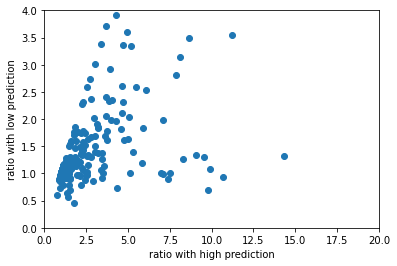

In [566]:
proj_campaign['diff_to_hi'] = proj_campaign['pred_preloads_hi']/proj_campaign['avg_preloads']
proj_campaign['diff_to_lo'] = proj_campaign['pred_preloads_lo']/proj_campaign['avg_preloads']
plt.xlim([0,20])
plt.ylim(0,4)
plt.scatter('diff_to_hi','diff_to_lo', data = proj_campaign)
plt.xlabel('ratio with high prediction')
plt.ylabel('ratio with low prediction')
proj_campaign.sort_values(['diff_to_lo','avg_preloads'], ascending = [True, False]).head(20)

<AxesSubplot:xlabel='date,hour'>

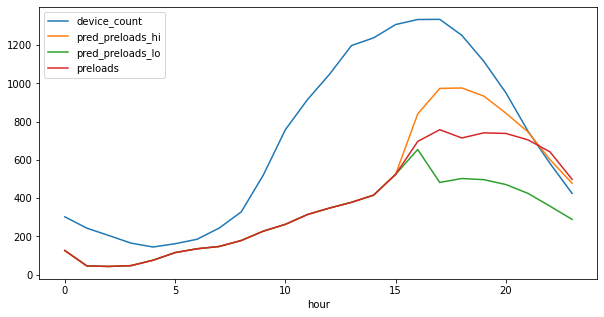

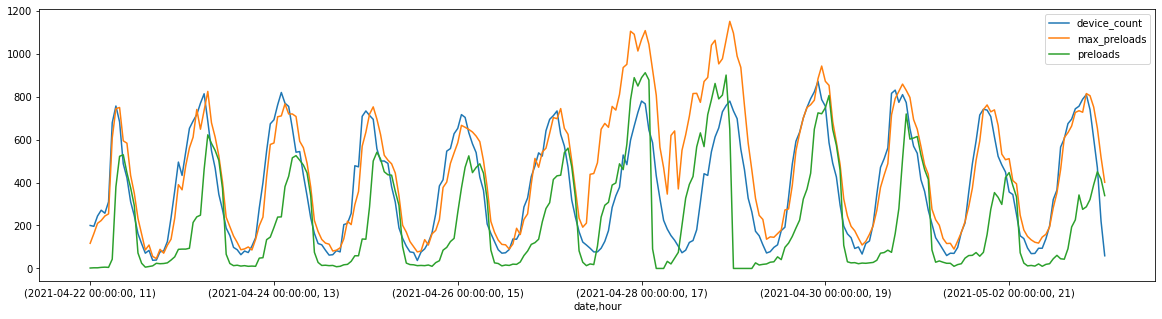

In [567]:
cid = 34395
sid = 11159
filters = (~proj_byhour.campaign_id.isna()) & (proj_byhour.campaign_id == cid) #& (proj_byhour.site_id == sid)
filters2 = (~by_date_hour.campaign_id.isna()) & (by_date_hour.campaign_id == cid) #& (by_date_hour.site_id == sid) & (by_date_hour.date == '2021-04-25')
proj_byhour[filters].pivot_table(values = ['device_count','preloads','pred_preloads_lo','pred_preloads_hi'], index = 'hour', aggfunc = np.sum).plot(figsize = (10,5))
by_date_hour.loc[filters2].pivot_table(values = ['preloads','max_preloads','device_count'], index = ['date','hour'], aggfunc = np.sum).plot(figsize = (20,5), sharex = True)


In [568]:
filters = (proj_byhour.campaign_id == cid) & (proj_byhour.min_cap_hour < 17)
proj_byhour[filters].pivot_table(values = ['device_count','max_preloads','mean_cap_hour','min_cap_hour','preloads','pred_preloads_hi','pred_preloads_lo']
                                 , index = 'site_id', aggfunc = {'device_count':sum
                                                                ,'max_preloads':sum
                                                                ,'min_cap_hour':'max'
                                                                ,'mean_cap_hour':'mean'
                                                                , 'pred_preloads_hi':sum
                                                                , 'pred_preloads_lo':sum
                                                                , 'preloads':sum
                                                                })
                                                                 

device_count  max_preloads  mean_cap_hour  min_cap_hour  \
site_id                                                            
12224     3777.222186   4135.879978      22.218447          16.0   

         pred_preloads_hi  pred_preloads_lo    preloads  
site_id                                                  
12224         1319.010089        318.670135  903.678788